In [15]:
import numpy as np
import matplotlib.pyplot as plt

### Funciones de Percolaciones de Paredes 

In [16]:
def permutation():
    global order,N
    order = np.random.permutation(N)

# Setting the boundaries no PBC utilizando case, no hay vecino EMPTY
def vecino(s,j):
    global L,empty
    
    if j == 0: #izquierda
        if s%L ==0:
            return empty
        else:
            return s-1
    elif j==1: #derecha
        if s%L == L-1:
            return empty
        else:
            return s+1
    elif j==2: #abajo
        if s//L == 0:
            return empty
        else:
            return s-L
    elif j==3: #arriba
        if s//L == L-1:
            return empty
        else:
            return s+L
                
def boundaries():
    global N,nn
    for s in range(N):
        for j in range(4):
            nn[s,j] = vecino(s,j)

# Find operation de la raiz, versión no recursiva, no se cambian los ptr.
def findroot(r):
    global parent
    while parent[r] >= 0:
        r = parent[r]
    return r

In [17]:
#union de raíces (clusters), version no recursiva
def mergeroots(r1,r2):
    global spanclussize,parent,touchesLeft,touchesRight
    if r1 == r2:
        return r1
    elif -parent[r1] > -parent[r2]:
        parent[r1] += parent[r2]
        parent[r2] = r1
        #si alguno de los dos toca a la izquierda el compuesto tocará
        touchesLeft[r1] = touchesLeft[r1] or touchesLeft[r2] 
        #si alguno de los dos toca a la derecha  el compuesto tocará
        touchesRight[r1] = touchesRight[r1] or touchesRight[r2]
        if touchesLeft[r1] and touchesRight[r1]:
            #si el cluster toca a la izquierda y a la derecha existirá aglomerado expnadido
            spanclussize = -parent[r1]
        return r1 
    else:
        parent[r2] += parent[r1]
        parent[r1] = r2
        #si alguno de los dos toca a la izquierda el compuesto tocará
        touchesLeft[r2] = touchesLeft[r2] or touchesLeft[r1]
        #si alguno de los dos toca a la derecha  el compuesto tocará
        touchesRight[r2] = touchesRight[r2] or touchesRight[r1]
        if touchesLeft[r2] and touchesRight[r2]:
            #si el cluster toca a la izquierda y a la derecha existirá aglomerado expnadido
            spanclussize = -parent[r2]
        return r2        

In [18]:
def percolate():
    global spanclussize,order,parent,nn
    BIG = []
    PSpan = []
    big=0
    spanclussize = 0
    
    #for i in range(N): parent[i]=empty    

    for i in range(N):
        r1=s1=order[i]
        parent[s1] = -1
                
        for j in range(4):
            s2=nn[s1, j]
            if s2 != empty:
                if parent[s2] != empty:
                    r1 = mergeroots(r1,findroot(s2))
                    if -parent[r1]>big: big=-parent[r1]
        BIG.append(big)
        PSpan.append(spanclussize/(i+1.))

    return np.array(BIG), np.array(PSpan)

### Variando L

In [19]:
global L, N, empty, parent, nn, order, spanclussize, touchesLeft, touchesRight

# Lista de tamaños del sistema
sizes = [16, 32, 64, 128, 256]
muestras = 100  # Número de realizaciones

# Diccionarios para almacenar los resultados promedio para cada tamaño
bigprom_dict = {}
Pspanprom_dict = {}
Probprom_dict = {}

for L in sizes:
    N = L**2
    empty = -(N + 1)
    nn = np.zeros((N, 4), dtype=int)
    boundaries()

    bigprom = np.zeros(N)
    Pspanprom = np.zeros(N)
    Probprom = np.zeros(N)
    order = np.zeros(N, dtype=int)
    touchesLeft = np.arange(N) % L == 0
    touchesRight = np.arange(N) % L == L - 1

    for _ in range(muestras):
        parent = empty * np.ones(N, dtype=int)
        permutation()
        boundaries()
        BIG, PSpan = percolate()
        Prob = np.copy(PSpan)
        Prob[PSpan > 0] = 1
        bigprom += BIG
        Pspanprom += PSpan
        Probprom += Prob

    bigprom /= muestras
    Pspanprom /= muestras
    Probprom /= muestras

    bigprom_dict[L] = bigprom / N
    Pspanprom_dict[L] = Pspanprom
    Probprom_dict[L] = Probprom

### Gráficas

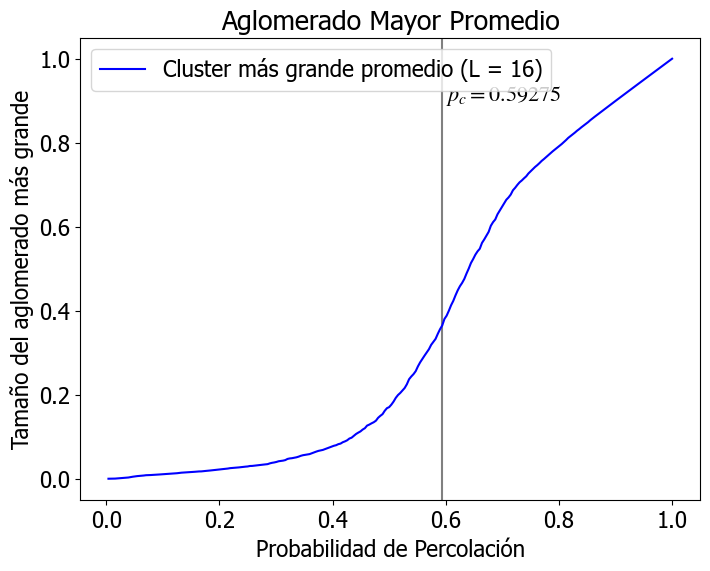

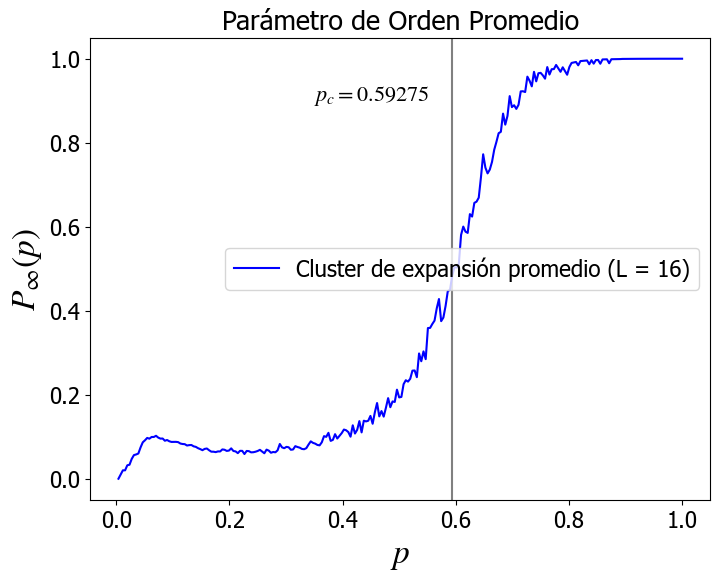

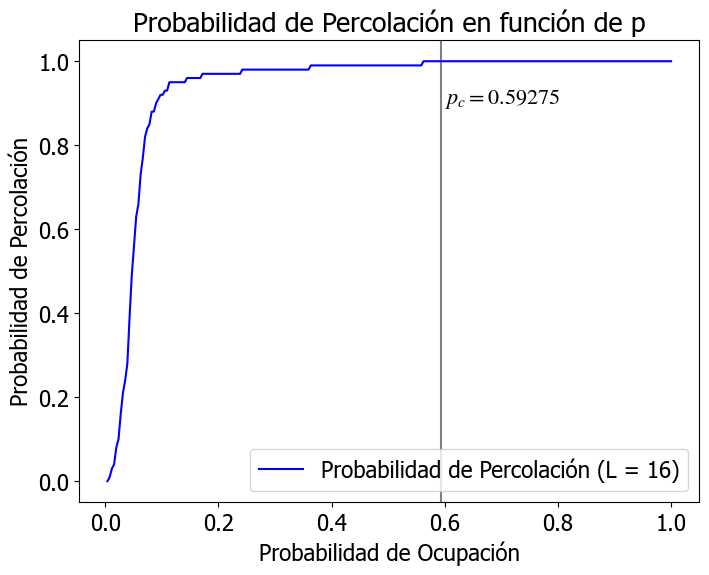

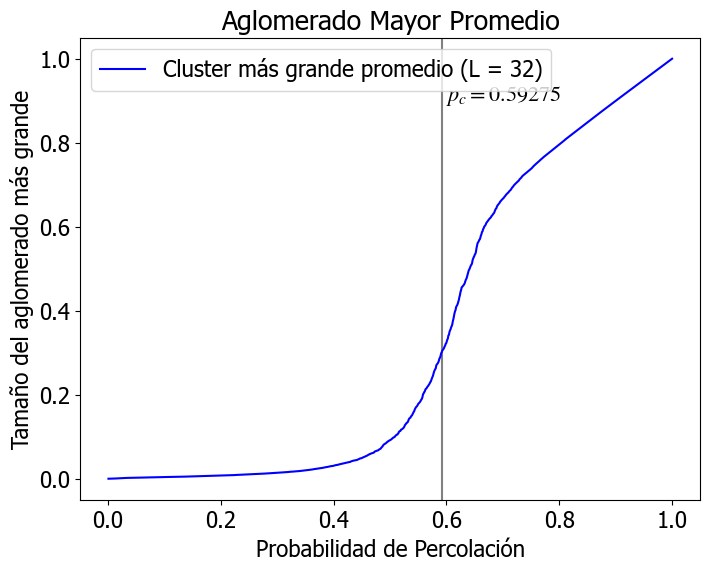

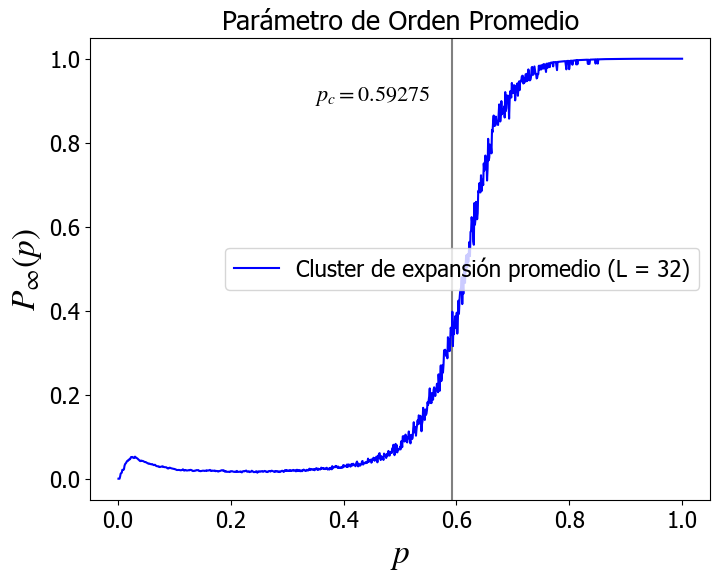

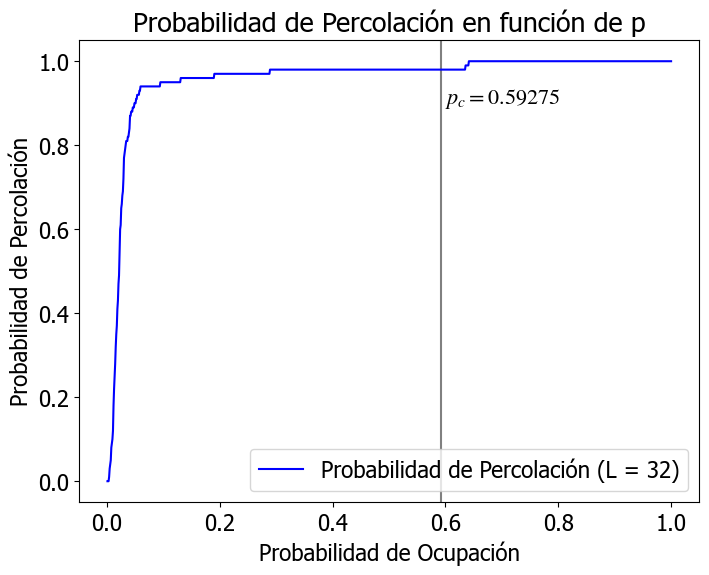

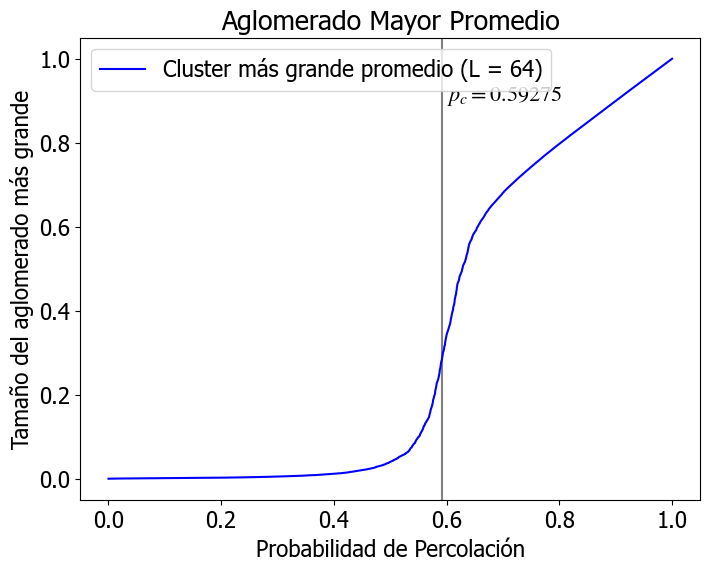

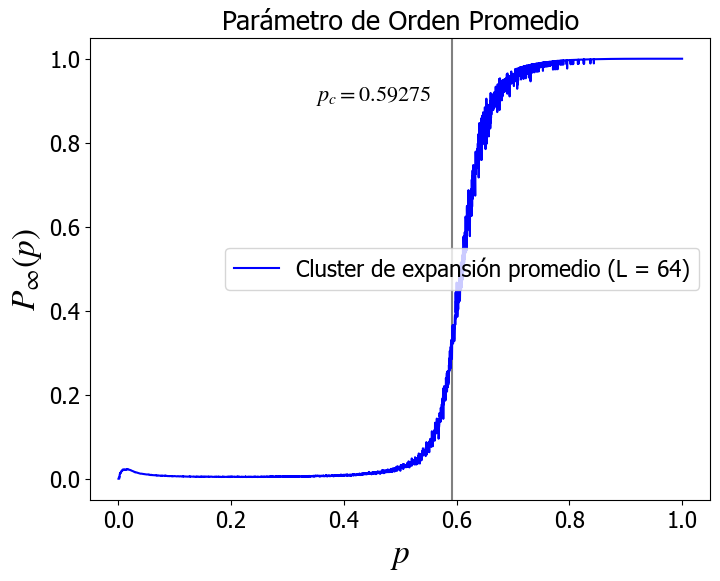

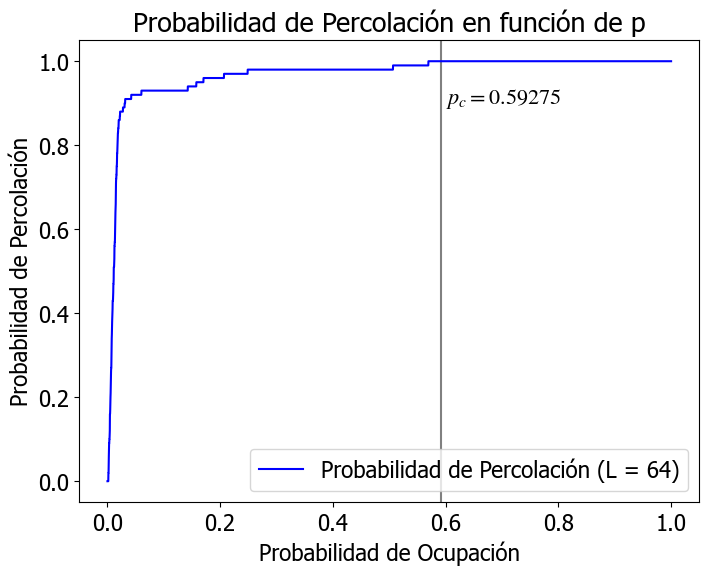

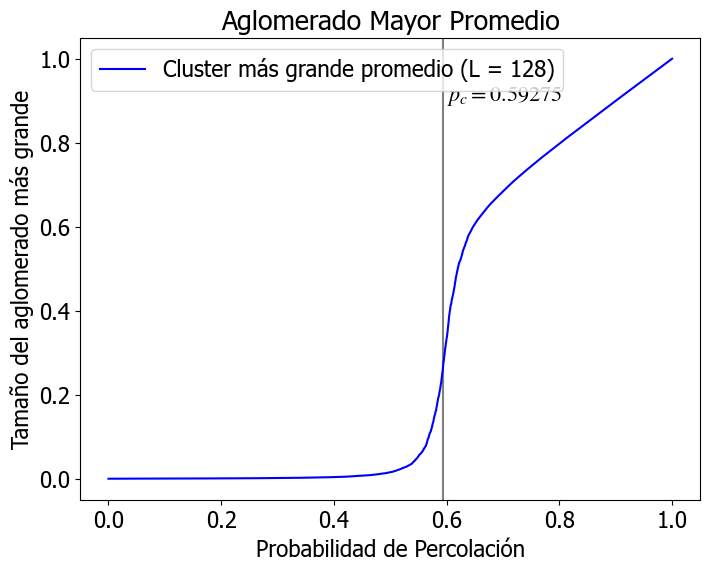

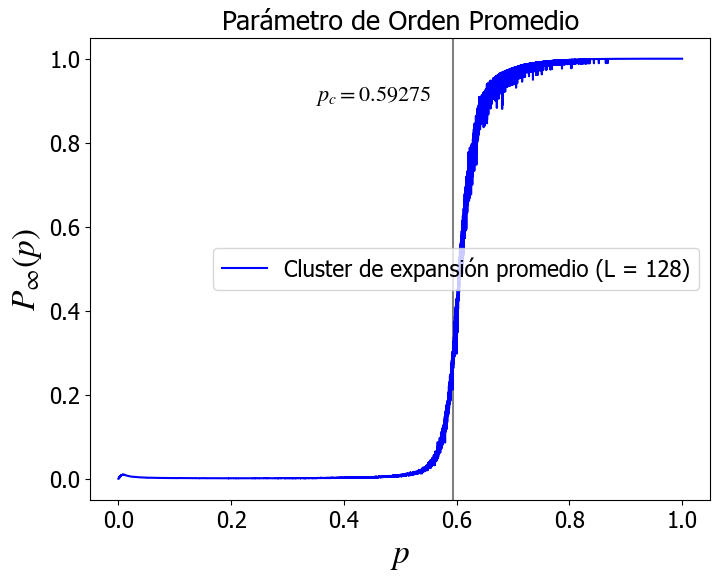

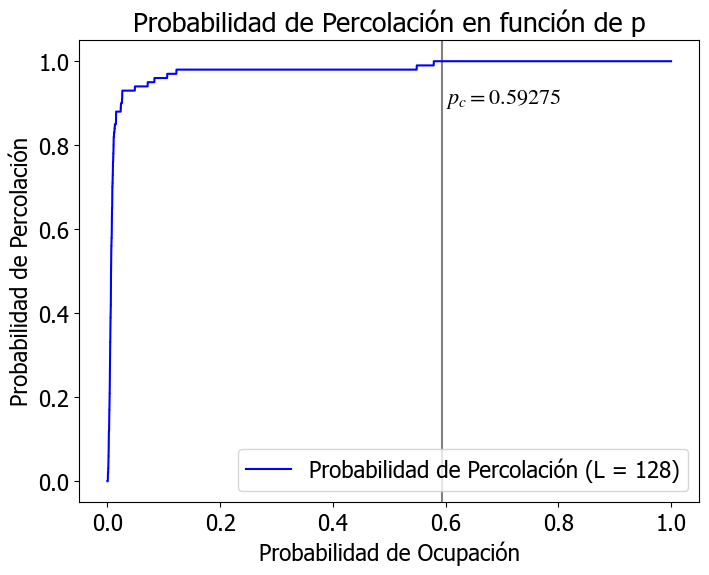

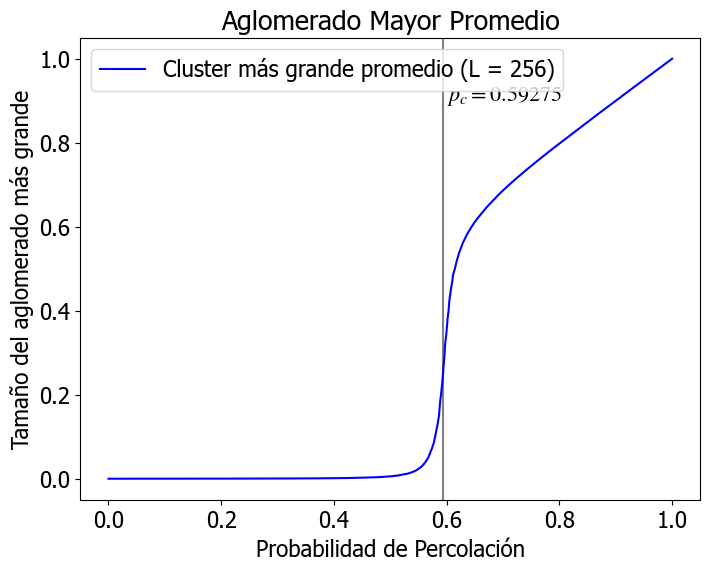

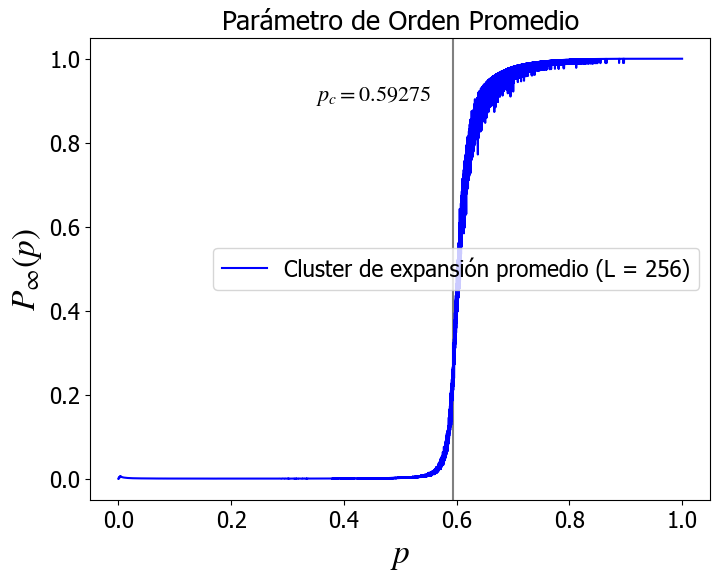

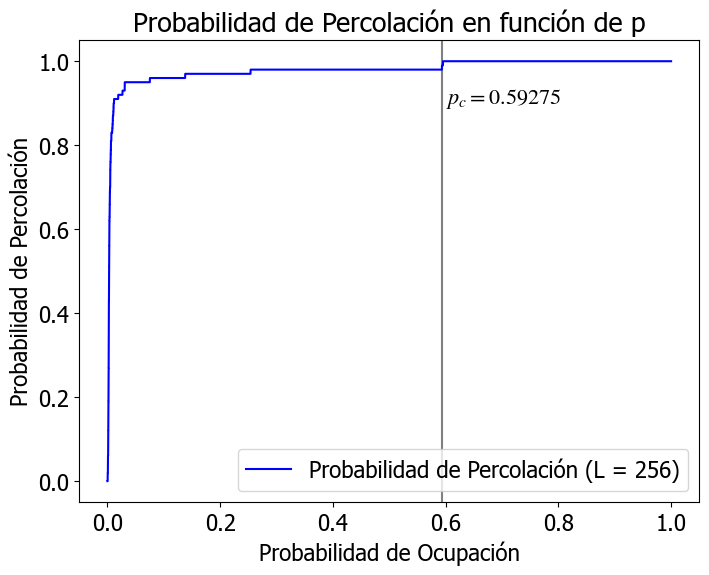

In [20]:
# Configuración de estilo de las gráficas
plt.rcParams['font.size'] = '16'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Tahoma']
plt.rc('mathtext', fontset='stix')

# Gráficas
for L in sizes:
    N = L**2
    p = np.arange(1, N + 1) / N
    
    # Gráfica del aglomerado más grande
    plt.figure(figsize=(8, 6))
    plt.plot(p, bigprom_dict[L], 'b-', label=f"Cluster más grande promedio (L = {L})")
    plt.xlabel("Probabilidad de Percolación")
    plt.ylabel("Tamaño del aglomerado más grande")
    plt.title("Aglomerado Mayor Promedio")
    plt.axvline(0.59275, color="gray", zorder=-1)
    plt.text(0.6, 0.9 * max(bigprom_dict[L]), r'$p_c = 0.59275$')
    plt.legend()
    plt.show()

    # Gráfica del parámetro de orden
    plt.figure(figsize=(8, 6))
    plt.plot(p, Pspanprom_dict[L], 'b-', label=f"Cluster de expansión promedio (L = {L})")
    plt.xlabel(r"$p$", fontsize=24)
    plt.ylabel(r'$P_\infty(p)$', fontsize=24)
    plt.title("Parámetro de Orden Promedio")
    plt.axvline(0.59275, color="gray", zorder=-1)
    plt.text(0.35, 0.9, r'$p_c = 0.59275$')
    plt.legend()
    plt.show()

    # Gráfica de la probabilidad de percolación
    plt.figure(figsize=(8, 6))
    plt.plot(p, Probprom_dict[L], 'b-', label=f"Probabilidad de Percolación (L = {L})")
    plt.xlabel("Probabilidad de Ocupación")
    plt.ylabel("Probabilidad de Percolación")
    plt.title("Probabilidad de Percolación en función de p")
    plt.axvline(0.59275, color="gray", zorder=-1)
    plt.text(0.6, 0.9, r'$p_c = 0.59275$')
    plt.legend()
    plt.show()

### Discusión